(384, 512, 3)


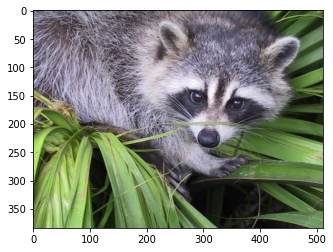

In [157]:
from imageio import imread
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy
import math
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import math
import pdb;

img = Image.open('racoon.jpg')
# plt.imshow(img)
print(np.shape(img))
plt.show()
racoon = imread('racoon.jpg')
# plt.imshow(racoon)
newrac = racoon/255
plt.imshow(newrac)

In [158]:
#downscale image
#Pad image
#get neighborhood for each pixel
#match up said neighborhood with original image corresponding pixel
#triplicate each neighborhood 3 times so to match with each color of each pixel
#put each neighborhood/pixel pair into a matrix
#set up matrix in the proper way for least squares regression
#run the calculations

In [159]:
def calcRegression(images):
    neighborhoods = []

    images0r = []
    images0g = []
    images0b = []
    images1r = []
    images1g = []
    images1b = []
    images2r = []
    images2g = []
    images2b = []
    images3r = []
    images3g = []
    images3b = []
    
    for image in images:
        #convert image to 0-1 values as imread opens them as values 0-255
        image = image/255
        downscaled = downscaleByHalf(image)
        if not neighborhoods:
            neighborhoods = getNeighborhoods(downscaled,5)
        else:
            np.concatenate((neighborhoods,getNeighborhoods(downscaled,5)))
        im0,im1,im2,im3 = breakupImage(image)
        images0r.append(im0[:,:,0])
        images0g.append(im0[:,:,1])
        images0b.append(im0[:,:,2])
        images1r.append(im1[:,:,0])
        images1g.append(im1[:,:,1])
        images1b.append(im1[:,:,2])
        images2r.append(im2[:,:,0])
        images2g.append(im2[:,:,1])
        images2b.append(im2[:,:,2])
        images3r.append(im3[:,:,0])
        images3g.append(im3[:,:,1])
        images3b.append(im3[:,:,2])

    neighborhoods = np.insert(neighborhoods,0,1,axis =1)
        
    # b vectors (original size images) reshaped to be vectors
    r0 = np.vstack(np.reshape(images0r,-1))
    g0 = np.vstack(np.reshape(images0g,-1))
    b0 = np.vstack(np.reshape(images0b,-1))
    r1 = np.vstack(np.reshape(images1r,-1))
    g1 = np.vstack(np.reshape(images1g,-1))
    b1 = np.vstack(np.reshape(images1b,-1))
    r2 = np.vstack(np.reshape(images2r,-1))
    g2 = np.vstack(np.reshape(images2g,-1))
    b2 = np.vstack(np.reshape(images2b,-1))
    r3 = np.vstack(np.reshape(images3r,-1))
    g3 = np.vstack(np.reshape(images3g,-1))
    b3 = np.vstack(np.reshape(images3b,-1))


    #regressions
    result0r = np.linalg.lstsq(neighborhoods, r0, rcond=None)[0]
    result0g = np.linalg.lstsq(neighborhoods, g0, rcond=None)[0]
    result0b = np.linalg.lstsq(neighborhoods, b0, rcond=None)[0]
    result1r = np.linalg.lstsq(neighborhoods, r1, rcond=None)[0]
    result1g = np.linalg.lstsq(neighborhoods, g1, rcond=None)[0]
    result1b = np.linalg.lstsq(neighborhoods, b1, rcond=None)[0]
    result2r = np.linalg.lstsq(neighborhoods, r2, rcond=None)[0]
    result2g = np.linalg.lstsq(neighborhoods, g2, rcond=None)[0]
    result2b = np.linalg.lstsq(neighborhoods, b2, rcond=None)[0]
    result3r = np.linalg.lstsq(neighborhoods, r3, rcond=None)[0]
    result3g = np.linalg.lstsq(neighborhoods, g3, rcond=None)[0]
    result3b = np.linalg.lstsq(neighborhoods, b3, rcond=None)[0]
    
    results = [result0r, result0g, result0b, result1r, result1g, result1b, result2r, result2g, result2b, result3r, result3g, result3b]
    
    return results 
        


In [200]:
def upscaleImg(img, regressions):
    neighborhoods = getNeighborhoods(img, 5)
#     neighborhoods = np.insert(neighborhoods,0,1,axis =1)

    #pixelColorValues
    PCV = []
    #get rid of the higher dimension
    print(np.shape(regressions))
    clippedRegressions = []
    for regression in regressions:
        regression = regression[1:]
        clippedRegressions.append(regression)
#     regressions = regressions[:,:,:]
    print(np.shape(clippedRegressions))
    for i in range (0,12):
        values = neighborhoods @ clippedRegressions[i]
        PCV.append(values)

    maxIndex = 0
    print("length ", np.shape(PCV[0]))
    finalImageWidth = np.shape(img)[1] * 2
    finalImageHeight = np.shape(img)[0] * 2
    toReturn = np.ndarray(shape=(finalImageHeight,finalImageWidth,3))
    for curRow in range(0,finalImageHeight):
        #every we only add an offset for every other row and max offset will only be half the width of upscaled image
        rowOffset = curRow//2 * (finalImageWidth//2)
        for curCol in range(0,finalImageWidth):
            #placeToIndex 
            pti = curCol//2 + rowOffset
            if pti > maxIndex:
                maxIndex = pti
            if curRow % 2 == 0:
                if curCol % 2 == 0:
                    pixels = [PCV[0][pti],PCV[1][pti],PCV[2][pti]]
                    toReturn[curRow][curCol] = pixels
                else:
                    pixels = [PCV[3][pti],PCV[4][pti],PCV[5][pti]]
                    toReturn[curRow][curCol] = pixels
            else:
                if curCol % 2 == 0:
                    pixels = [PCV[6][pti],PCV[7][pti],PCV[8][pti]]
                    toReturn[curRow][curCol] = pixels
                else:
                    pixels = [PCV[9][pti],PCV[10][pti],PCV[11][pti]]
                    toReturn[curRow][curCol] = pixels

                    
#   for curRow in range(0,6):
#     result[curRow] = []
#     #every we only add an offset for every other row and max offset will only be half the width of upscaled image
#     rowOffset = curRow//2 * (finalImageWidth//2)
#     for curCol in range(0,8):
#         if curRow % 2 == 0:
#             if curCol % 2 == 0:
#                 result[curRow].append(a[(curCol//2) + rowOffset])
#             else:
#                 result[curRow].append(b[(curCol//2) + rowOffset])
#         else:
#             if curCol % 2 == 0:
#                 result[curRow].append(c[(curCol//2) + rowOffset])
#             else:
#                 result[curRow].append(d[(curCol//2) + rowOffset])
                
                    
    print("Max index", maxIndex)
    return toReturn
    


In [161]:
def downscaleByHalf(img, antiAliasing=False):
    toReturn = rescale(img, (0.5, 0.5, 1), anti_aliasing=antiAliasing)
    return toReturn

In [162]:
def padEdge(img,amount):
    padded = np.pad(img,((amount,amount),(amount,amount),(0,0)),mode='edge')
    return padded

In [163]:
def getNeighborhoods(image, neighborhoodWidth):
    neighborhoods = []
    neighborhoodWidth = abs(neighborhoodWidth)
    if (neighborhoodWidth%2 == 0):
        neighborhoodWidth = neighborhoodWidth - 1
    offset = math.floor(neighborhoodWidth/2)
    paddedImage = padEdge(image,offset)
    #for each pixel
    for row in range(offset,paddedImage.shape[0]-offset):
        for column in range(offset, paddedImage.shape[1]-offset):
            pixelToAdd = []
            #neighborhood loops
            for i in range(-offset,offset+1):
                for j in range(-offset,offset+1):
                    for k in range(0,3): #color
                        pixelToAdd.append(paddedImage[row+i,column+j,k])
            neighborhoods.append(pixelToAdd)
    return neighborhoods

In [164]:
def breakupImage(img):
    im1 = img[0::2,0::2,:] #start 1st row, 1st column
    im2 = img[0::2,1::2,:] #start 1st row, 2nd column
    im3 = img[1::2,0::2,:] #start 2nd row, 1st column
    im4 = img[1::2,1::2,:] #start 2nd row, 2nd column
    return im1,im2,im3,im4

In [165]:
images = []
images.append(racoon)
resRegression = calcRegression(images)


In [201]:
img = upscaleImg(racoon/255, resRegression)


(12, 76, 1)
(12, 75, 1)
length  (196608, 1)


<ipython-input-200-4ebbadf7aff8>:35: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  toReturn[curRow][curCol] = pixels
<ipython-input-200-4ebbadf7aff8>:38: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  toReturn[curRow][curCol] = pixels
<ipython-input-200-4ebbadf7aff8>:42: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the sa

Max index 196607


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(768, 1024, 3)
[-0.01964166 -0.01231908 -0.03700222 ... -0.03452032 -0.03735075
 -0.00790373]


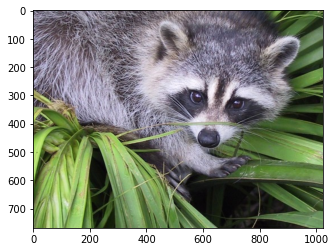

In [202]:
print(np.shape(img))
# print(img[0,0,0])
print(img[img<0])
plt.imshow(abs(img))

In [172]:
1//2

0

TypeError: Cannot interpret '1' as a data type

In [46]:
a = [1,3,5,7,17,19,21,23,33,35,37,39]
b = [2,4,6,8,18,20,22,24,34,36,38,40]
c = [9,11,13,15,25,27,29,31,41,43,45,47]
d = [10,12,14,16,26,28,30,32,42,44,46,48]

result = [-1,-1,-1,-1,-1,-1]
finalImageWidth = 8


for curRow in range(0,6):
    result[curRow] = []
    #every we only add an offset for every other row and max offset will only be half the width of upscaled image
    rowOffset = curRow//2 * (finalImageWidth//2)
    for curCol in range(0,8):
        if curRow % 2 == 0:
            if curCol % 2 == 0:
                result[curRow].append(a[(curCol//2) + rowOffset])
            else:
                result[curRow].append(b[(curCol//2) + rowOffset])
        else:
            if curCol % 2 == 0:
                result[curRow].append(c[(curCol//2) + rowOffset])
            else:
                result[curRow].append(d[(curCol//2) + rowOffset])
                
print(result)
        

offset 0
offset 0
offset 0
offset 0
offset 0
offset 0
offset 0
offset 0
offset 0
offset 0
offset 0
offset 0
offset 0
offset 0
offset 0
offset 0
offset 4
offset 4
offset 4
offset 4
offset 4
offset 4
offset 4
offset 4
offset 4
offset 4
offset 4
offset 4
offset 4
offset 4
offset 4
offset 4
offset 8
offset 8
offset 8
offset 8
offset 8
offset 8
offset 8
offset 8
offset 8
offset 8
offset 8
offset 8
offset 8
offset 8
offset 8
offset 8
[[1, 2, 3, 4, 5, 6, 7, 8], [9, 10, 11, 12, 13, 14, 15, 16], [17, 18, 19, 20, 21, 22, 23, 24], [25, 26, 27, 28, 29, 30, 31, 32], [33, 34, 35, 36, 37, 38, 39, 40], [41, 42, 43, 44, 45, 46, 47, 48]]


In [ ]:
#testingCode

In [40]:
a = [[[0, 1, 0],
  [1, 2, 0],
  [1, 3, 0],
  [1, 4, 0],
  [1, 5, 0]],

 [[2, 1, 0],
  [2, 2, 0],
  [2, 3, 0],
  [2, 4, 0],
  [2, 5, 0]],

 [[3, 1, 0],
  [3, 2, 0],
  [102, 103, 104],
  [3, 4, 0],
  [3, 5, 0]],

 [[4, 1, 0],
  [4, 2, 0],
  [4, 3, 0],
  [4, 4, 0],
  [4, 5, 0]],

 [[5, 1, 0],
  [5, 2, 0],
  [5, 3, 0],
  [5, 4, 0],
  [5, 5, 0]]]

# imagestest = []
# rchannel = racoon[:,:,0]
# gchannel = racoon[:,:,1]
# imagestest.append(rchannel)
# imagestest.append(gchannel)
# imagestest = np.reshape(imagestest,-1)

# print(imagestest)

# letters = [[["a","b","c"]]]

neighborhoods = getNeighborhoods(racoon,5)
neighborhoods2 = getNeighborhoods(racoon,5)
# print(neighborhoods)
# n2 = np.repeat(neighborhoods,3, 0)
print('hello')
# print(n2)
print(len(neighborhoods))
print(np.shape(neighborhoods))

# b= np.reshape(a,-1)
# np.vstack(b)
# b = np.vstack(a)
# print("hello b", b)
# print(b.shape)
# c = np.reshape(b,-1)
# d = np.vstack(c)
# print(d)
# print(d.shape)

hello
196608
(196608, 75)


In [51]:
both = np.concatenate((neighborhoods, neighborhoods2))
print(np.shape(both))

img2 = []
img2.append(np.reshape(racoon[:,:,0],-1))
print(np.shape(img2))
img2.append(np.reshape(racoon[:,:,1],-1))
print(np.shape(img2))

(393216, 75)
(1, 196608)
(2, 196608)


In [146]:
a = [[1,2,3],[0,1,4],[5,6,0]]
b = [10,11,12]

inv = np.linalg.inv(a)

act = inv @ b
res = np.linalg.lstsq(a,b,rcond = None)[0]
print(act)
print(res)

[ 18. -13.   6.]
[ 18. -13.   6.]
